Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


Generating charmm system in vacuum


/data/shared/software/python_env/anaconda3/envs/rew/lib/python3.9/site-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")


nnpops CUDA
platform='CUDA'
env='vacuum'
ml_atoms=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
/data/shared/software/python_env/anaconda3/envs/rew/lib/python3.9/site-packages/torchani/resources/
converting pickle file ...
Number of samples loaded: 4400


100%|██████████| 4400/4400 [00:13<00:00, 328.70it/s]


#-----------------------------------------#


Free energy difference: -940543.7199069955
Free energy uncertainty: 0.07795397235041714
#-----------------------------------------#
FEP
#####################################################
# ------------------- FEP ---------------------------
#####################################################
Performing bidirectional protocol ...
Instantanious switching: dE will be calculated


100%|██████████| 5000/5000 [00:48<00:00, 104.11it/s]


Instantanious switching: dE will be calculated


100%|██████████| 5000/5000 [00:48<00:00, 102.86it/s]


#--------------- SUMMARY ---------------#
Zwanzig's equation (from mm to qml): {'Delta_f': -940543.6379217816, 'dDelta_f': 0.5709931457032964}
Zwanzig's equation (from qml to mm): {'Delta_f': 940546.2219744433, 'dDelta_f': 0.43209396795616295}
Zwanzig's equation bidirectional: {'Delta_f': -940544.1575133228, 'dDelta_f': 0.14236392175827983}
Jarzynski's equation (from mm to qml): {'Delta_f': -940545.6405343976, 'dDelta_f': 0.1823943619678441}
Jarzynski's equation (from qml to mm): {'Delta_f': 940543.8016212193, 'dDelta_f': 0.030675814922736144}
Crooks' equation: {'Delta_f': -940543.8412822594, 'dDelta_f': 0.027185758781778067}
Equilibrium free energy: -940543.7199069955+/-0.07795397235041714
#--------------------------------------#


#################
[-940543.7199069955, -940543.8412822594, -940545.6405343976, -940544.1575133228, -940543.6379217816]


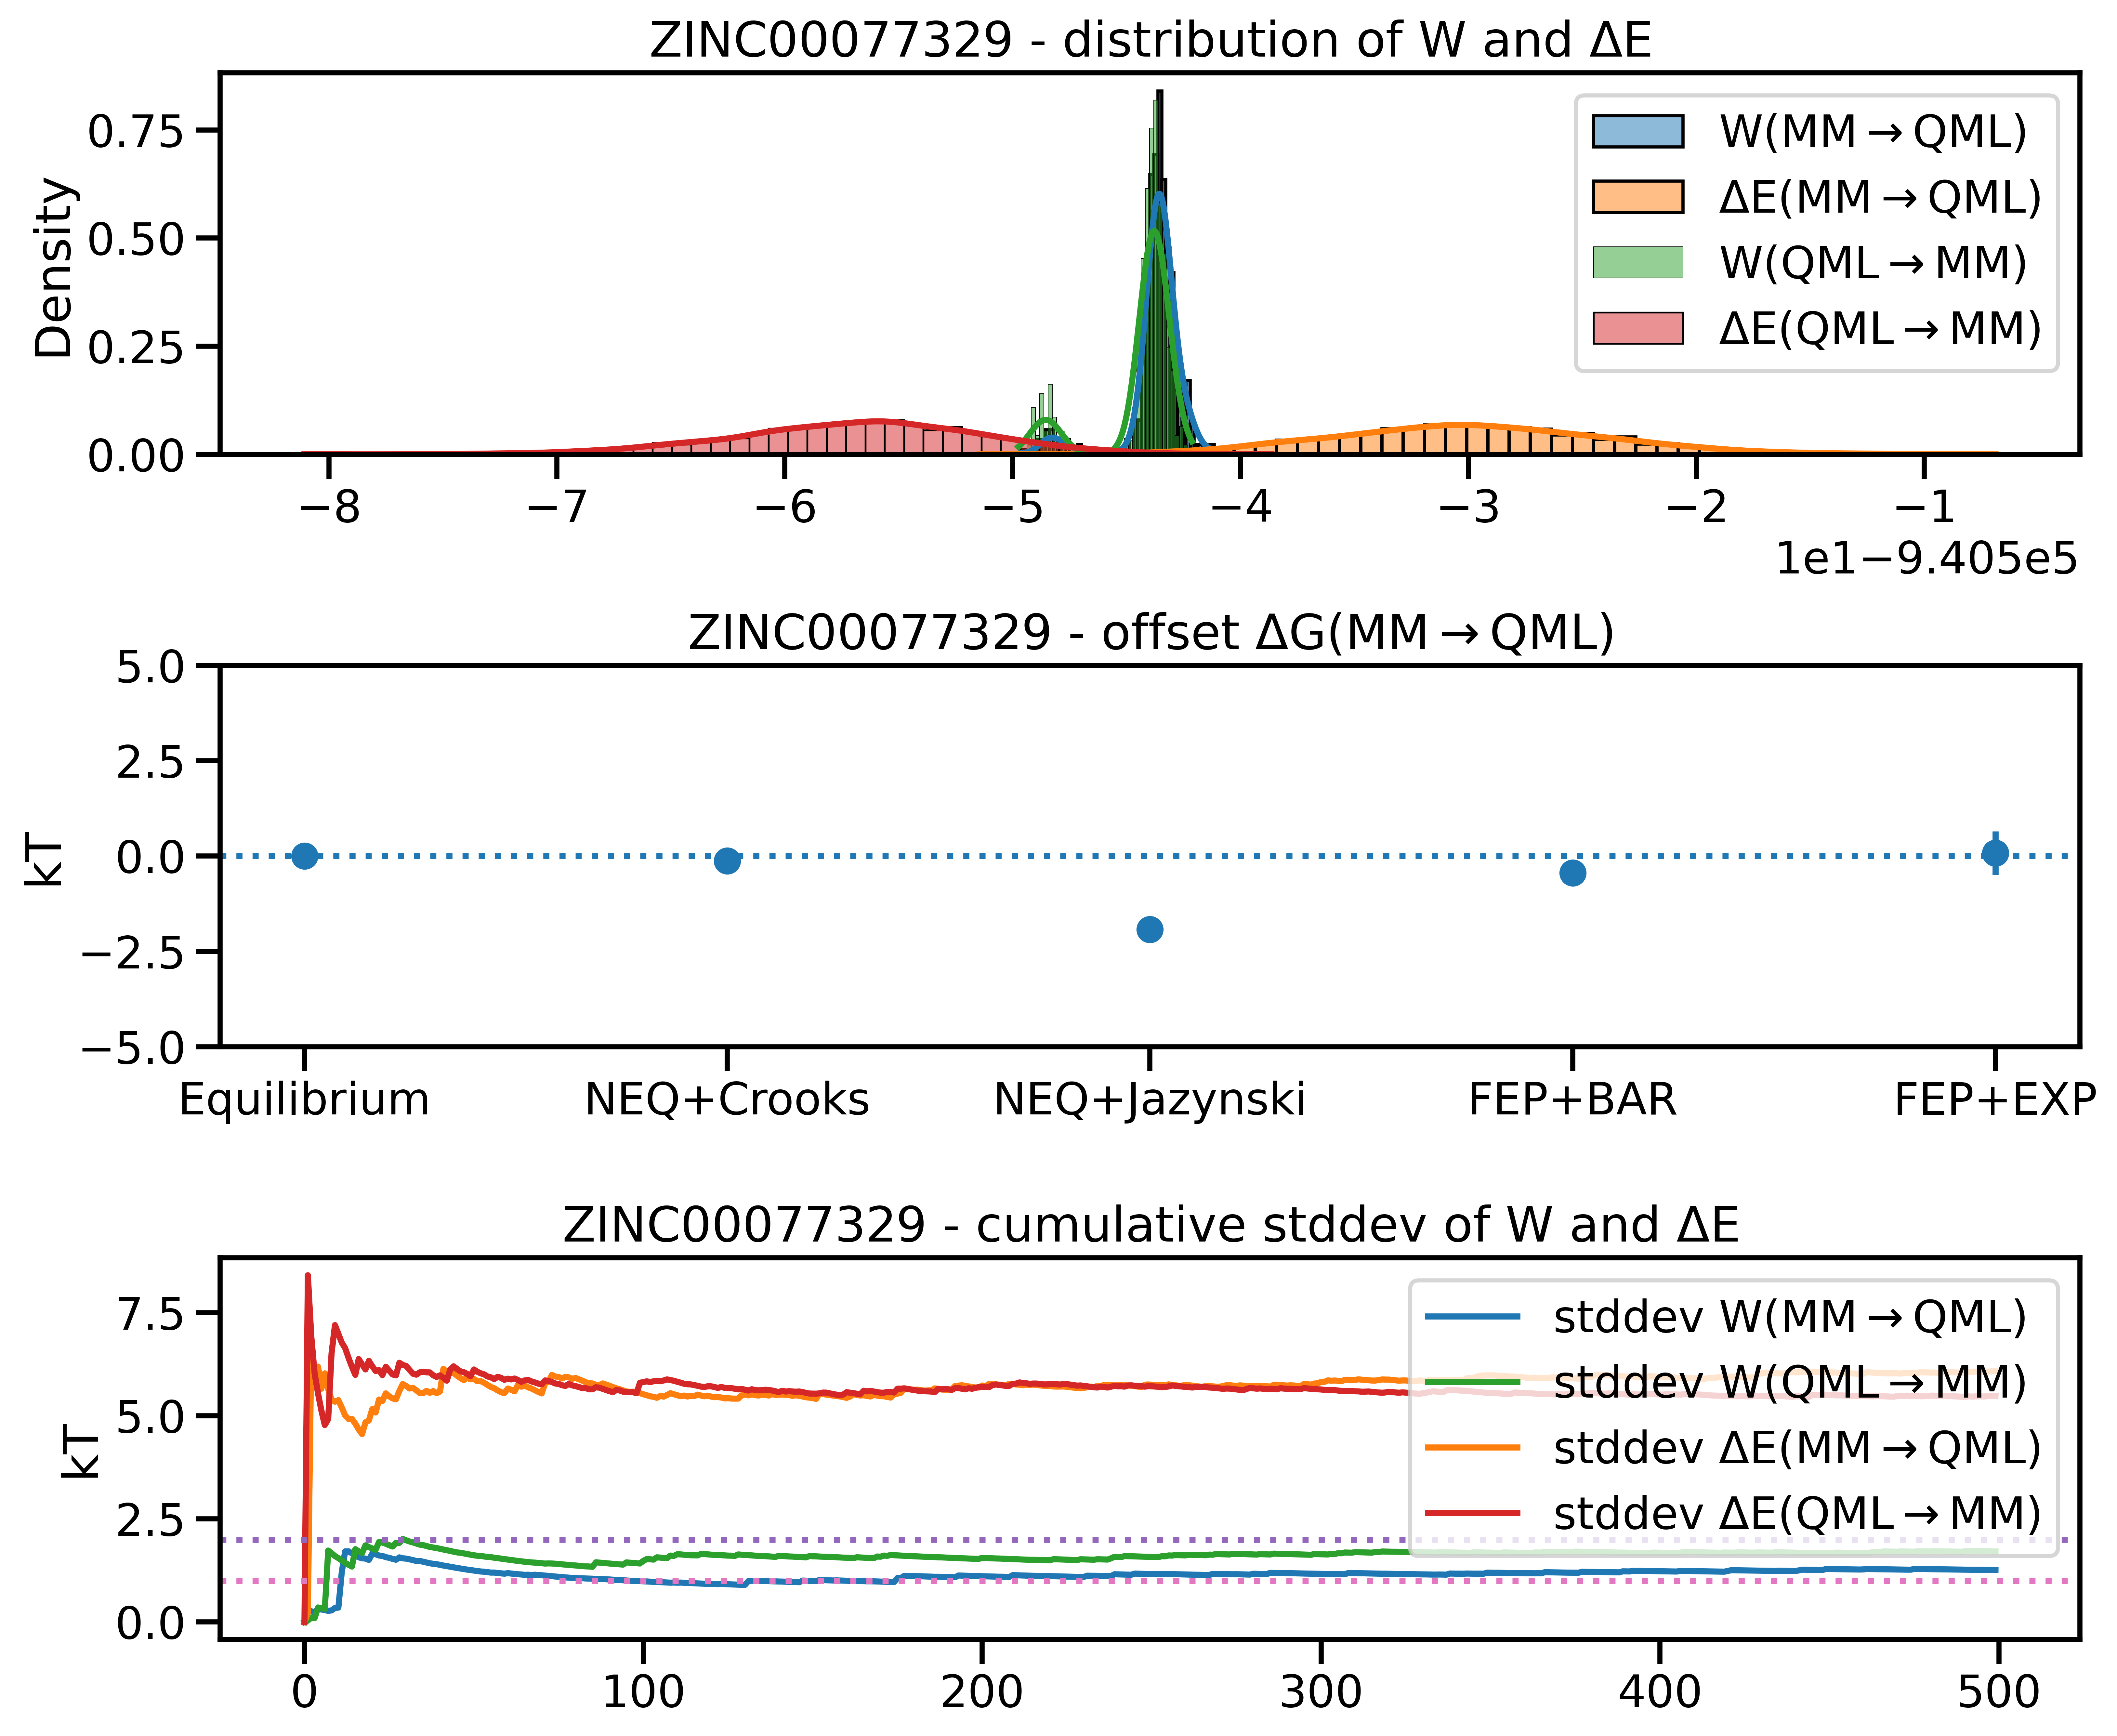

In [1]:
from endstate_correction.analysis import (
    plot_overlap_for_equilibrium_free_energy,
    plot_results_for_equilibrium_free_energy,
)
from endstate_correction.equ import calculate_u_kn
import pathlib
import endstate_correction
from endstate_correction.system import create_charmm_system
from openmm.app import CharmmParameterSet, CharmmPsfFile, CharmmCrdFile
import glob, pickle
import numpy as np
from openmm import unit
import mdtraj as md
from endstate_correction.utils import convert_pickle_to_dcd_file
from endstate_correction.constant import kBT
from pymbar import mbar
from endstate_correction.protocol import Results, Protocol, perform_endstate_correction
from endstate_correction.analysis import plot_endstate_correction_results
import pickle

def load_equ_samples(
    system_name: str, base:str, nr_of_samples: int = 5_000, nr_of_steps: int = 1_000, run_id:int = 1
)->list:
    """Helper function that loads trajectories from the test data"""

    trajs = []
    path = f"{base}/{system_name}/sampling_charmmff/run{run_id:02d}/"

    for lamb in np.linspace(0, 1, 11):
        file = glob.glob(
            f"{path}/{system_name}_samples_{nr_of_samples}_steps_{nr_of_steps}_lamb_{lamb:.4f}.dcd"
        )
        if len(file) == 2:
            raise RuntimeError("Multiple traj files present. Abort.")
        if len(file) == 0:
            raise RuntimeError(
                "WARNING! Incomplete equ sampling. Proceed with cautions."
            )

        trajs.append(md.open(file[0]).read()[0] * unit.angstrom)
    return trajs

def convert_pickle_files(system_name: str, base:str, path_to_psf:str, path_to_crd:str, nr_of_samples: int = 5_000, nr_of_steps: int = 1_000, run_id:int=1):
    """Helper function that converts pickle to dcd files"""
    path = f"{base}/{system_name}/sampling_charmmff/run{run_id:02d}/"

    for lamb in np.linspace(0, 1, 11):
        file = glob.glob(
            f"{path}/{system_name}_samples_{nr_of_samples}_steps_{nr_of_steps}_lamb_{lamb:.4f}.pickle"
        )
        if file[0]:
            dcd_output_path = f"{path}/{system_name}_samples_{nr_of_samples}_steps_{nr_of_steps}_lamb_{lamb:.4f}.dcd"
            pdb_output_path = f"{path}/{system_name}.pdb"
            convert_pickle_to_dcd_file(file[0], path_to_psf, path_to_crd, dcd_output_path, pdb_output_path)

########################################################
########################################################
# ----------------- vacuum -----------------------------
# get all relevant files
path = pathlib.Path(endstate_correction.__file__).resolve().parent
hipen_testsystem = f"{path}/data/hipen_data"

system_name = "ZINC00077329"
path_to_psf = f"{hipen_testsystem}/{system_name}/{system_name}.psf"
path_to_crd = f"{hipen_testsystem}/{system_name}/{system_name}.crd"
psf = CharmmPsfFile(path_to_psf)
coord = CharmmCrdFile(path_to_crd)
params = CharmmParameterSet(
    f"{hipen_testsystem}/top_all36_cgenff.rtf",
    f"{hipen_testsystem}/par_all36_cgenff.prm",
    f"{hipen_testsystem}/{system_name}/{system_name}.str",
)
# define region that should be treated with the qml
chains = list(psf.topology.chains())
ml_atoms = [atom.index for atom in chains[0].atoms()]
# create openmm simulation system
sim = create_charmm_system(
    psf=psf, parameters=params, env="vacuum", ml_atoms=ml_atoms
)

# convert pickle files if necessary
print('converting pickle file ...')
convert_pickle_files(system_name, '/data/shared/projects/endstate_rew', path_to_psf, path_to_crd)
# load all trajectories
trajs = load_equ_samples(system_name, '/data/shared/projects/endstate_rew')
# calculate input for MBAR
N_k, u_kn = calculate_u_kn(
    trajs=trajs,
    every_nth_frame=10,
    sim=sim,
)

# calculate equilibrium free energy difference
print('#-----------------------------------------#')
m = mbar.MBAR(u_kn, N_k)
print(f'Free energy difference: {m.compute_free_energy_differences()["Delta_f"][0][-1]}')
print(f'Free energy uncertainty: {m.compute_free_energy_differences()["dDelta_f"][0][-1]}')
print('#-----------------------------------------#')


# load all trajectories
mm_trajs = []
qml_trajs = []
for i in [1,2,3]:
    # convert pickle files if necessary
    convert_pickle_files(system_name, '/data/shared/projects/endstate_rew', path_to_psf, path_to_crd, run_id = i)
    trajs = load_equ_samples(system_name, '/data/shared/projects/endstate_rew', run_id = i)
    mm_trajs.extend(trajs[0])
    qml_trajs.extend(trajs[-1])

# perform FEP
fep_protocol = Protocol(
    method="FEP",
    direction="bidirectional",
    sim=sim,
    trajectories=[mm_trajs, qml_trajs],
    nr_of_switches=5_000,
)
r = perform_endstate_correction(fep_protocol)

# load NEQ results
r.W_mm_to_qml = pickle.load(open(f'/data/shared/projects/endstate_rew/{system_name}/switching_charmmff/{system_name}_neq_ws_from_mm_to_qml_500_5001.pickle', 'rb')) /kBT
r.W_qml_to_mm = pickle.load(open(f'/data/shared/projects/endstate_rew/{system_name}/switching_charmmff/{system_name}_neq_ws_from_qml_to_mm_500_5001.pickle', 'rb')) /kBT
# put mbar in results object
r.equ_mbar = mbar.MBAR(u_kn, N_k)

plot_endstate_correction_results(
    system_name, r, f"{system_name}_results.png"
)


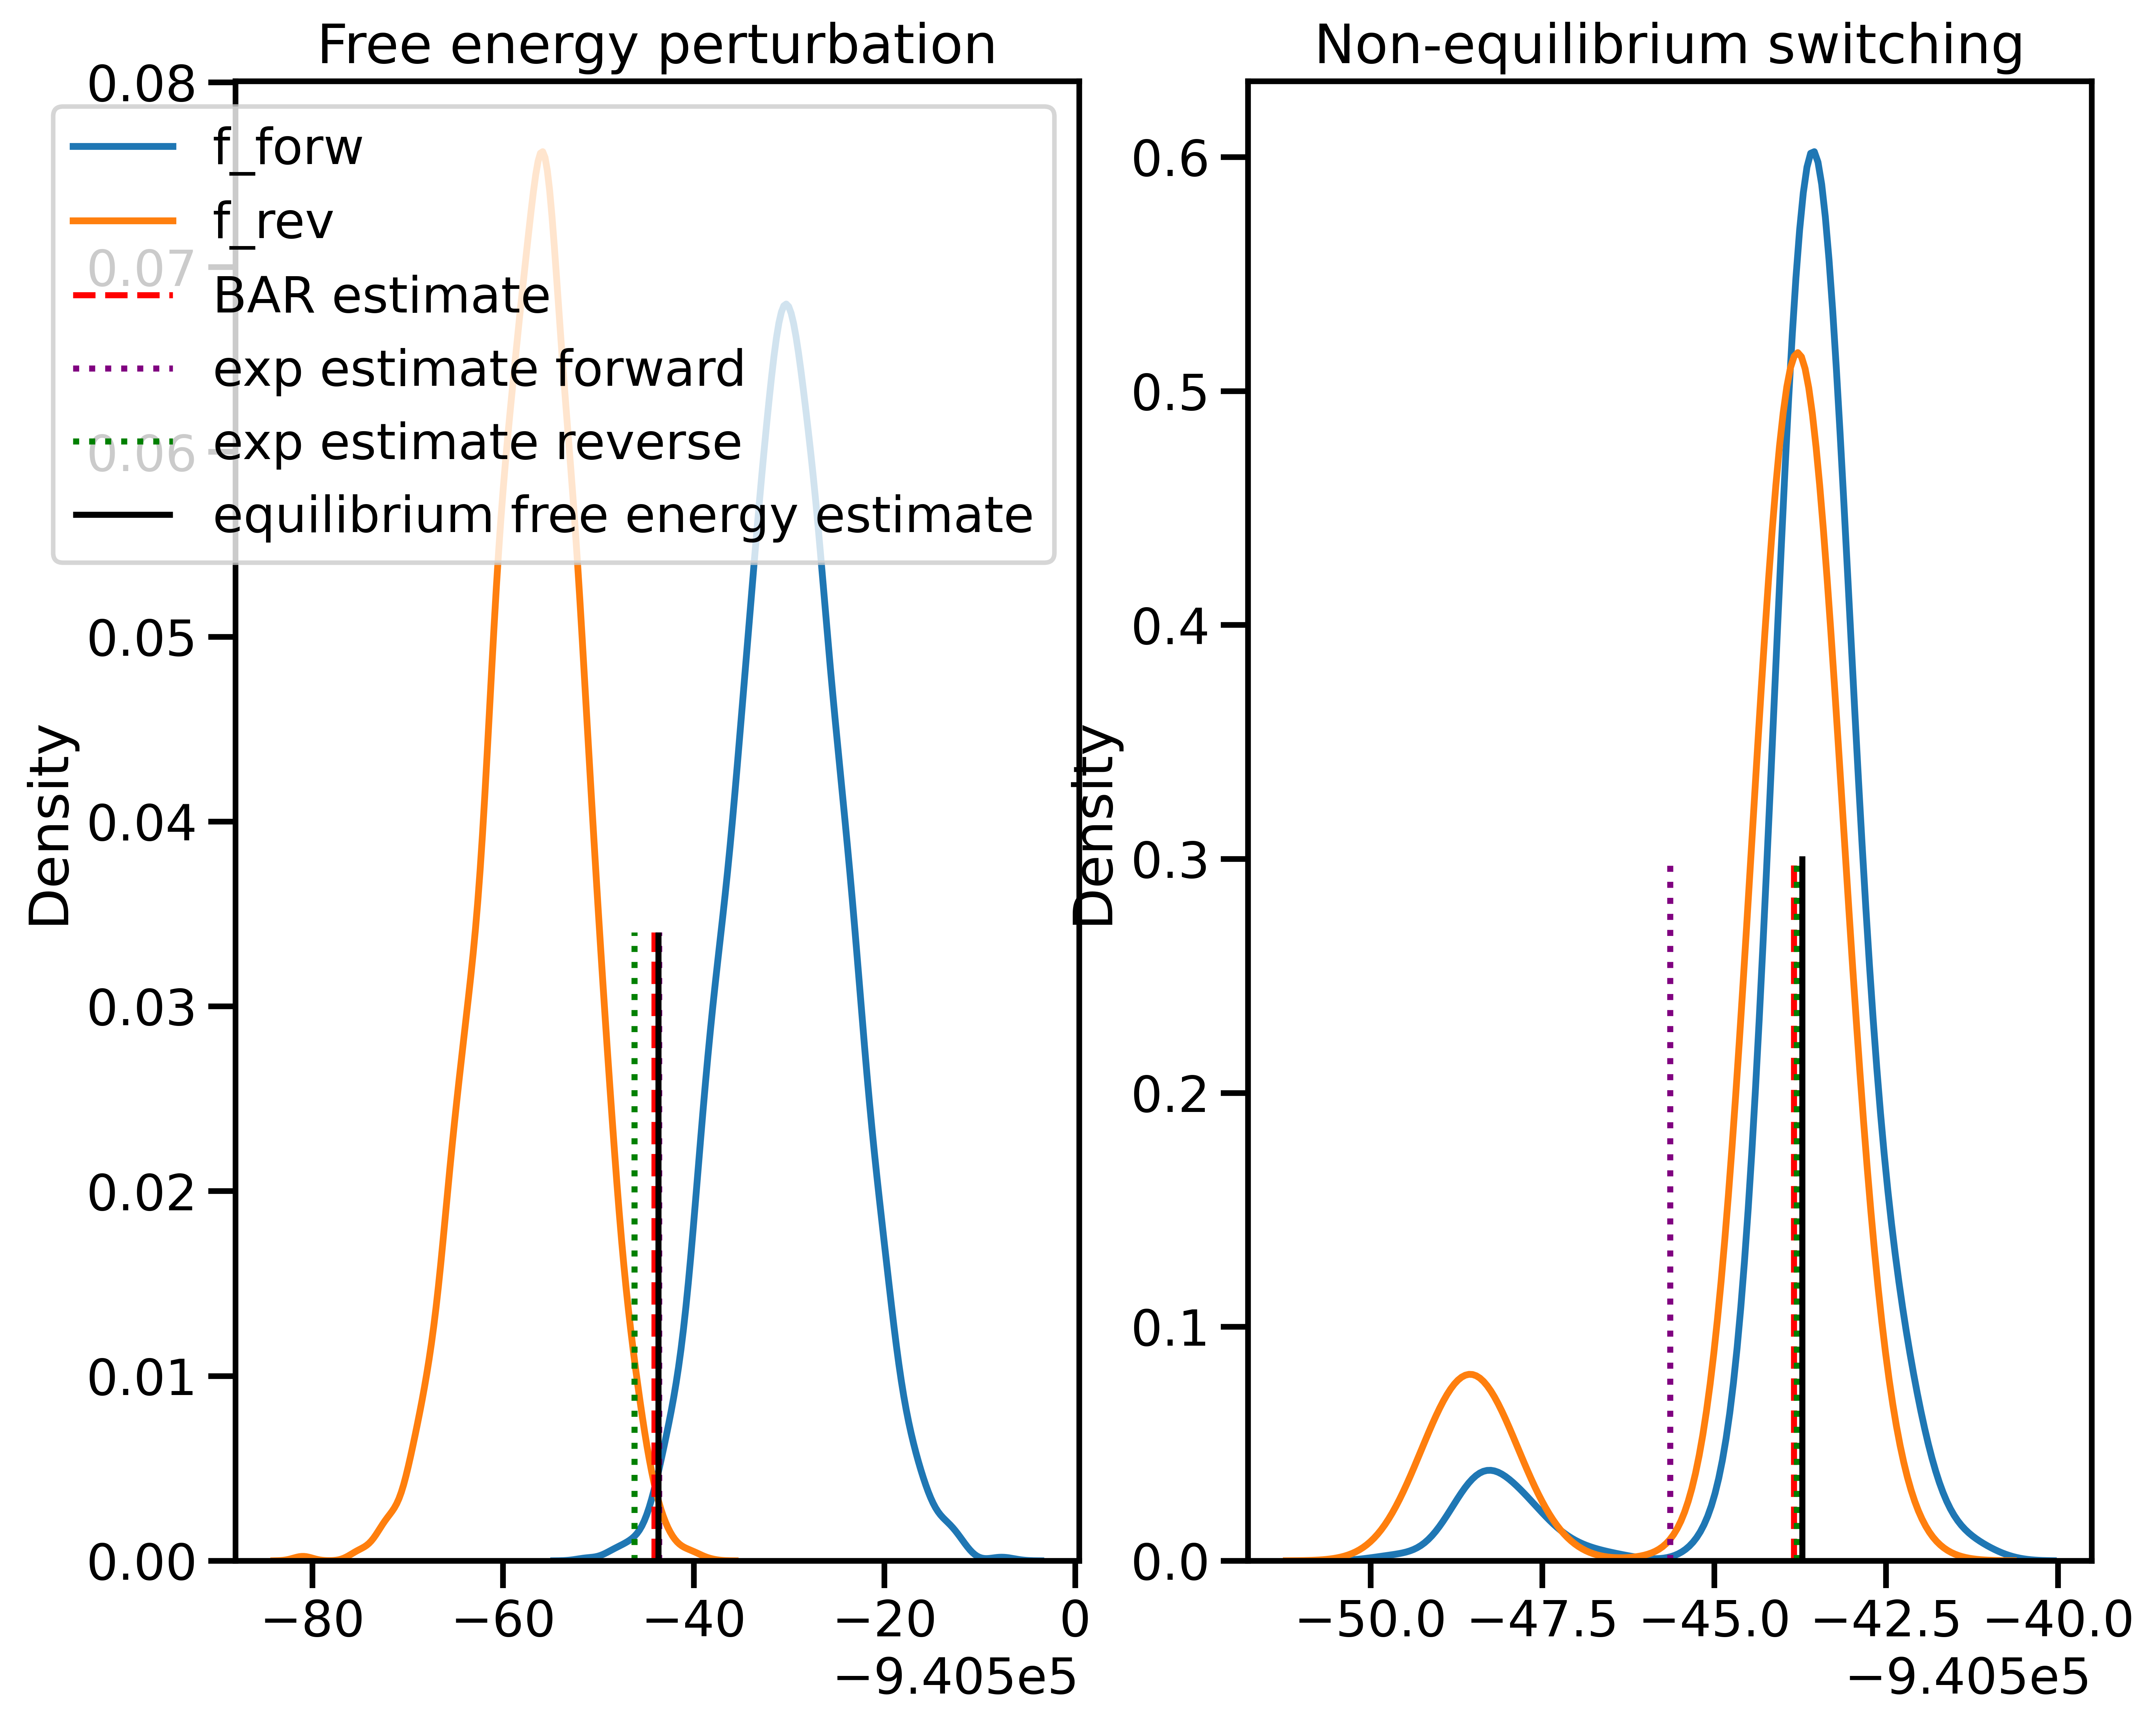

In [2]:
import seaborn as sns
from pymbar import bar
from pymbar.other_estimators import exp
import matplotlib.pyplot as plt

# draw histogramms and results for FEP and NEQ
# start with FEP
w_F, w_R = r.dE_mm_to_qml, r.dE_qml_to_mm
results = bar(w_F, w_R)
rexp_f = exp(w_F)
rexp_r = exp(w_R)
fig, axs = plt.subplots(1, 2, figsize=(11.0, 9), dpi=600)

axs[0].set_title('Free energy perturbation')
ax = sns.kdeplot(w_F, label='f_forw', ax=axs[0])
kde_curve = ax.lines[0]
y1 = kde_curve.get_ydata().max()
ax = sns.kdeplot(w_R*-1, label='f_rev', ax=axs[0])
kde_curve = ax.lines[0]
y2 = kde_curve.get_ydata().max()

axs[0].vlines(x = results["Delta_f"], ymin = 0, ymax = max(y1, y2)/2,
           colors = 'red',lw=2,ls='--',
           label = 'BAR estimate')
axs[0].vlines(x = rexp_f["Delta_f"], ymin = 0, ymax = max(y1, y2)/2,
           colors = 'purple', lw=2,ls=':',
           label = 'exp estimate forward')
axs[0].vlines(x = rexp_r["Delta_f"]*-1, ymin = 0, ymax = max(y1, y2)/2,
           colors = 'green',lw=2,ls=':',
           label = 'exp estimate reverse')
axs[0].vlines(r.equ_mbar.compute_free_energy_differences()["Delta_f"][0][-1], ymin = 0, ymax = max(y1, y2)/2,
           colors = 'black',lw=2,ls='-',
           label = 'equilibrium free energy estimate')


# now NEQ
w_F, w_R = r.W_mm_to_qml, r.W_qml_to_mm
results = bar(w_F, w_R)
rexp_f = exp(w_F)
rexp_r = exp(w_R)
axs[1].set_title('Non-equilibrium switching')

ax = sns.kdeplot(w_F, label='f_forw', ax=axs[1])
kde_curve = ax.lines[0]
y1 = kde_curve.get_ydata().max()
ax = sns.kdeplot(w_R*-1, label='f_rev', ax=axs[1])
kde_curve = ax.lines[0]
y2 = kde_curve.get_ydata().max()

axs[1].vlines(x = results["Delta_f"], ymin = 0, ymax = max(y1, y2)/2,
           colors = 'red',lw=2,ls='--',
           label = 'BAR estimate')
axs[1].vlines(x = rexp_f["Delta_f"], ymin = 0, ymax = max(y1, y2)/2,
           colors = 'purple', lw=2,ls=':',
           label = 'exp estimate forward')
axs[1].vlines(x = rexp_r["Delta_f"]*-1, ymin = 0, ymax = max(y1, y2)/2,
           colors = 'green',lw=2,ls=':',
           label = 'exp estimate reverse')
axs[1].vlines(r.equ_mbar.compute_free_energy_differences()["Delta_f"][0][-1], ymin = 0, ymax = max(y1, y2)/2,
           colors = 'black',lw=2,ls='-',
           label = 'equilibrium free energy estimate')

axs[0].legend(loc='upper right',)
plt.show()